# Exercise 1

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
data = np.load('psths.npz')
X = data['X']         # Shape: (N, C, T) where N=182 neurons, C=108 conditions, T=130 time bins
times = data['times'] # Shape: (T,)

print(f"Shape of X: {X.shape}")
print(f"Shape of times: {times.shape}")


Shape of X: (182, 108, 130)
Shape of times: (130,)


In [ ]:
import random

# Set random seed for reproducibility
random.seed(42)

# Total number of neurons and conditions
N, C, T = X.shape

# Number of neurons and conditions to select
num_neurons = 5
num_conditions = 5

# Randomly select neurons and conditions
selected_neurons = random.sample(range(N), num_neurons)
selected_conditions = random.sample(range(C), num_conditions)

print(f"Selected Neurons (0-based indices): {selected_neurons}")
print(f"Selected Conditions (0-based indices): {selected_conditions}")


Selected Neurons (0-based indices): [163, 28, 6, 70, 62]
Selected Conditions (0-based indices): [28, 17, 94, 13, 86]


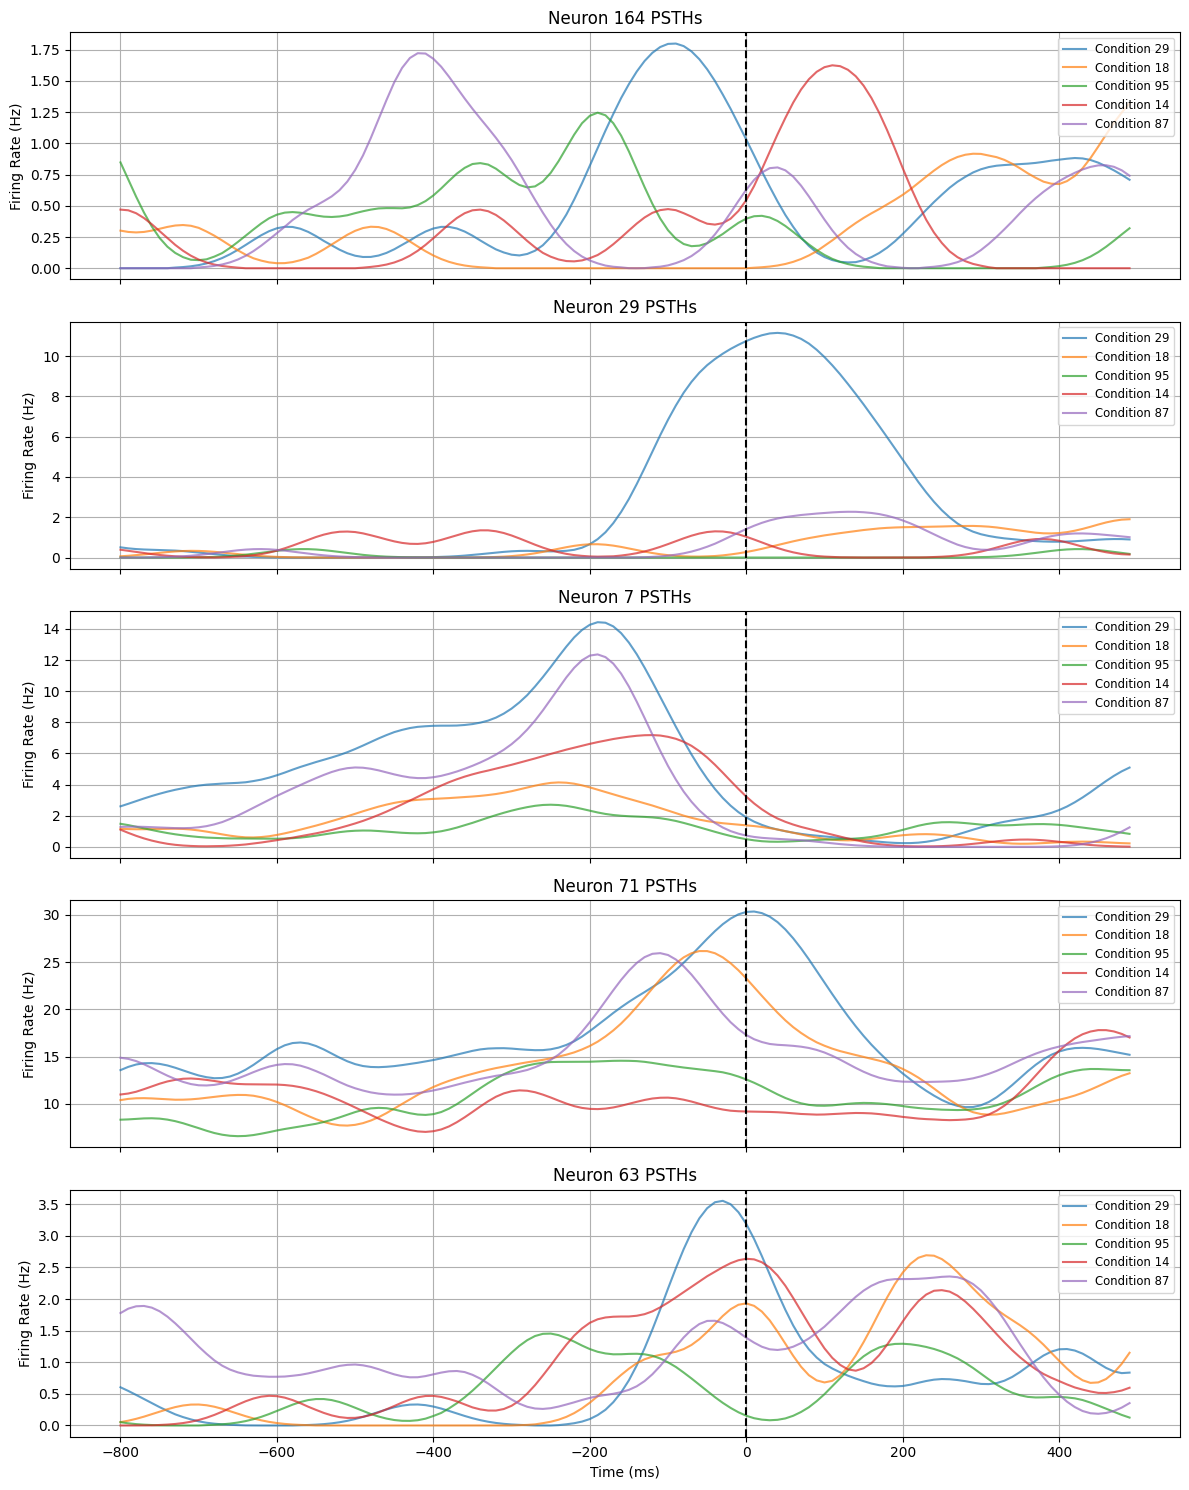

In [ ]:
import matplotlib.pyplot as plt

# Create a figure for PSTHs
fig, axes = plt.subplots(num_neurons, 1, figsize=(12, 3 * num_neurons), sharex=True)

# Define a colormap for conditions
cmap = plt.get_cmap('tab10')  # 'tab10' has 10 distinct colors
colors = [cmap(i % 10) for i in range(num_conditions)]  # Repeat colors if more than 10 conditions

for i, neuron in enumerate(selected_neurons):
    ax = axes[i]
    for j, condition in enumerate(selected_conditions):
        ax.plot(times, X[neuron, condition, :], label=f'Condition {condition+1}', color=colors[j], alpha=0.7)
    ax.set_title(f'Neuron {neuron+1} PSTHs')
    ax.set_ylabel('Firing Rate (Hz)')
    ax.axvline(x=0, color='k', linestyle='--')  # Movement onset at time 0
    ax.legend(loc='upper right', fontsize='small')
    ax.grid(True)

axes[-1].set_xlabel('Time (ms)')

plt.tight_layout()
plt.show()


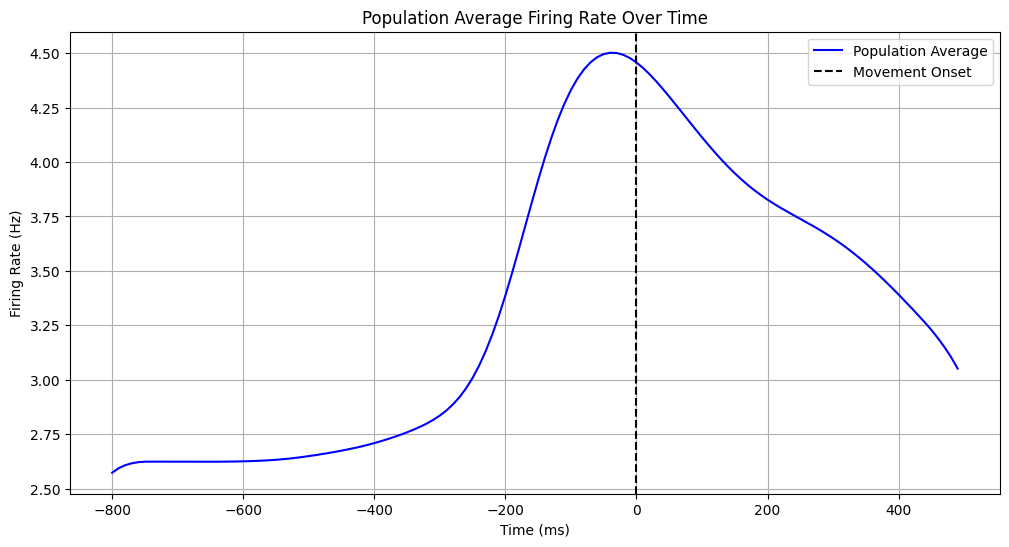

In [ ]:
# Compute the population average firing rate
population_average = np.mean(X, axis=(0, 1))  # Averaging over neurons and conditions

# Plot the population average firing rate
plt.figure(figsize=(12, 6))
plt.plot(times, population_average, color='blue', label='Population Average')
plt.title('Population Average Firing Rate Over Time')
plt.xlabel('Time (ms)')
plt.ylabel('Firing Rate (Hz)')
plt.axvline(x=0, color='k', linestyle='--', label='Movement Onset')
plt.legend()
plt.grid(True)
plt.show()


# Exercise 2

Normalisation

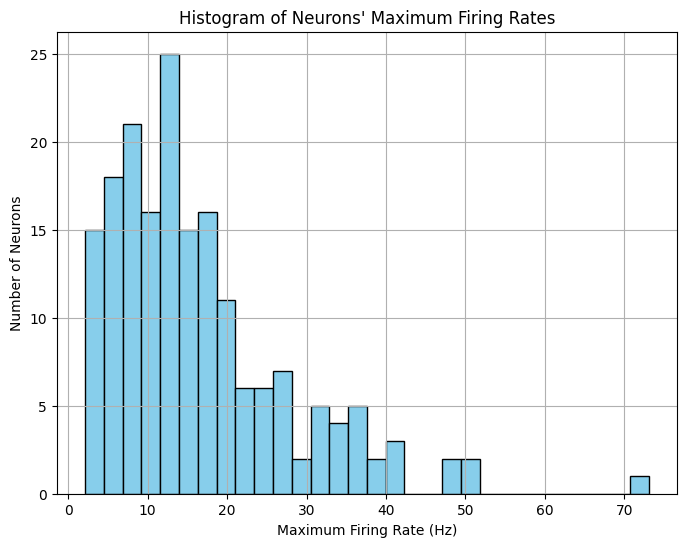

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
data = np.load('psths.npz')
X = data['X']        # Shape: (N=182, C=108, T=130)
times = data['times']  # Shape: (T=130,)

# Compute the maximum firing rate for each neuron across all conditions and time bins
max_firing_rates = X.max(axis=(1, 2))  # Shape: (N=182,)

plt.figure(figsize=(8, 6))
plt.hist(max_firing_rates, bins=30, color='skyblue', edgecolor='black')
plt.title("Histogram of Neurons' Maximum Firing Rates")
plt.xlabel('Maximum Firing Rate (Hz)')
plt.ylabel('Number of Neurons')
plt.grid(True)
plt.show()

In [ ]:
# Compute the maximum and minimum firing rates for each neuron
a = X.max(axis=(1, 2))  # Shape: (N=182,)
b = X.min(axis=(1, 2))  # Shape: (N=182,)

# Reshape 'a' and 'b' to enable broadcasting
a = a[:, np.newaxis, np.newaxis]  # Shape: (182, 1, 1)
b = b[:, np.newaxis, np.newaxis]  # Shape: (182, 1, 1)

# Apply the normalization formula
normalized_X = (X - b) / (a - b + 5)  # Broadcasting occurs here

# Verify the shape remains unchanged
print(f"Shape of normalized_X: {normalized_X.shape}")  # Should output (182, 108, 130)


Shape of normalized_X: (182, 108, 130)


Mean Centering

In [ ]:
# Compute the mean over conditions for each neuron and time bin
mean_over_conditions = normalized_X.mean(axis=1, keepdims=True)  # Shape: (182, 1, 130)

# Subtract the mean from the normalized PSTH to obtain the mean-centered data
centered_X = normalized_X - mean_over_conditions  # Broadcasting subtraction

# Verify the shape remains unchanged
print(f"Shape of centered_X: {centered_X.shape}")  # Should output (182, 108, 130)

Shape of centered_X: (182, 108, 130)


Dimensionality Reduction by PCA

In [ ]:
# Define the time interval of interest
start_time = -150  # in milliseconds
end_time = 300     # in milliseconds

# Create a boolean mask for selecting the desired time bins
selected_time_mask = (times >= start_time) & (times <= end_time)  # Shape: (130,)

# Apply the mask to select the relevant time bins
selected_times = times[selected_time_mask]  # Shape: (T_selected=46,)

# Slice the centered_X to include only the selected time bins
selected_X = centered_X[:, :, selected_time_mask]  # Shape: (182, 108, 46)

# Confirm the number of selected time bins
print(f"Selected time bins: {selected_times.shape[0]}")  # Should output 46

Selected time bins: 46


In [ ]:
# Get the dimensions
N, C, T_selected = selected_X.shape  # N=182, C=108, T_selected=46
CT = C * T_selected                  # CT=4968

# Reshape the data to (n_samples=CT, n_features=N)
# Transpose to have samples as rows
reshaped_X = selected_X.reshape(N, CT).T  # Shape: (4968, 182)

print(f"Shape of reshaped_X: {reshaped_X.shape}")  # Should output (4968, 182)


Shape of reshaped_X: (4968, 182)


In [ ]:
from sklearn.decomposition import PCA

# Define the number of principal components
M = 12

# Initialize the PCA model
pca = PCA(n_components=M)

# Fit PCA on the reshaped data
pca.fit(reshaped_X)

# Project the data onto the first M principal components
Z = pca.transform(reshaped_X).T  # Shape: (12, 4968)

# Retrieve the principal components (loadings)
V_M = pca.components_.T  # Shape: (182, 12)

print(f"Shape of Z: {Z.shape}")      # Should output (12, 4968)
print(f"Shape of V_M: {V_M.shape}")  # Should output (182, 12)


Shape of Z: (12, 4968)
Shape of V_M: (182, 12)


In [ ]:
# Access the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Print the variance explained by each principal component
for i, var in enumerate(explained_variance_ratio, start=1):
    print(f"Principal Component {i}: {var*100:.2f}% of variance")

# Calculate the cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

print(f"Cumulative variance explained by the first {M} components: {cumulative_explained_variance[-1]*100:.2f}%")


Principal Component 1: 13.64% of variance
Principal Component 2: 9.55% of variance
Principal Component 3: 7.95% of variance
Principal Component 4: 5.50% of variance
Principal Component 5: 4.88% of variance
Principal Component 6: 4.65% of variance
Principal Component 7: 3.89% of variance
Principal Component 8: 3.36% of variance
Principal Component 9: 3.18% of variance
Principal Component 10: 2.73% of variance
Principal Component 11: 2.41% of variance
Principal Component 12: 1.89% of variance
Cumulative variance explained by the first 12 components: 63.63%


# Exercise 3

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import importlib
from cond_color import get_colors, plot_start, plot_end # Ensure this matches the filename without .py

# Reshape Z to a 3D array: (PCs, Conditions, Time Bins)
# Original Z shape: (12, 4968) -> Reshaped to (12, 108, 46)
num_pcs, total_samples = Z.shape
num_conditions = 108
num_time_bins = 46

# Verify that total_samples equals num_conditions * num_time_bins
assert total_samples == num_conditions * num_time_bins, "Mismatch in total samples and condition-time combinations."

# Perform the reshaping
Z_reshaped = Z.reshape(num_pcs, num_conditions, num_time_bins)

print(f"Shape of Z_reshaped: {Z_reshaped.shape}")  # Expected: (12, 108, 46)

Shape of Z_reshaped: (12, 108, 46)


In [ ]:
# Extract PC1 and PC2
PC1 = Z_reshaped[0, :, :]  # Shape: (108, 46)
PC2 = Z_reshaped[1, :, :]  # Shape: (108, 46)

print(f"Shape of PC1: {PC1.shape}")  # Expected: (108, 46)
print(f"Shape of PC2: {PC2.shape}")  # Expected: (108, 46)

Shape of PC1: (108, 46)
Shape of PC2: (108, 46)


In [ ]:
# Extract the initial points of each trajectory (at -150 ms, t=0)
initial_PC1 = PC1[:, 0]  # Shape: (108,)
initial_PC2 = PC2[:, 0]  # Shape: (108,)

# Use the provided get_colors function to assign colors based on initial points
colors = get_colors(initial_PC1, initial_PC2)

# Verify the length of colors matches the number of conditions
assert len(colors) == num_conditions, "Number of colors does not match number of conditions."

print(f"First 5 colors: {colors[:5]}")

First 5 colors: [(0.5882352941176471, 0.0, 0.0, 1.0), (0.0, 0.7372549019607844, 0.0, 1.0), (0.0, 0.5294117647058824, 0.0, 1.0), (0.00784313725490196, 0.0, 0.0, 1.0), (0.0, 0.4627450980392157, 0.0, 1.0)]


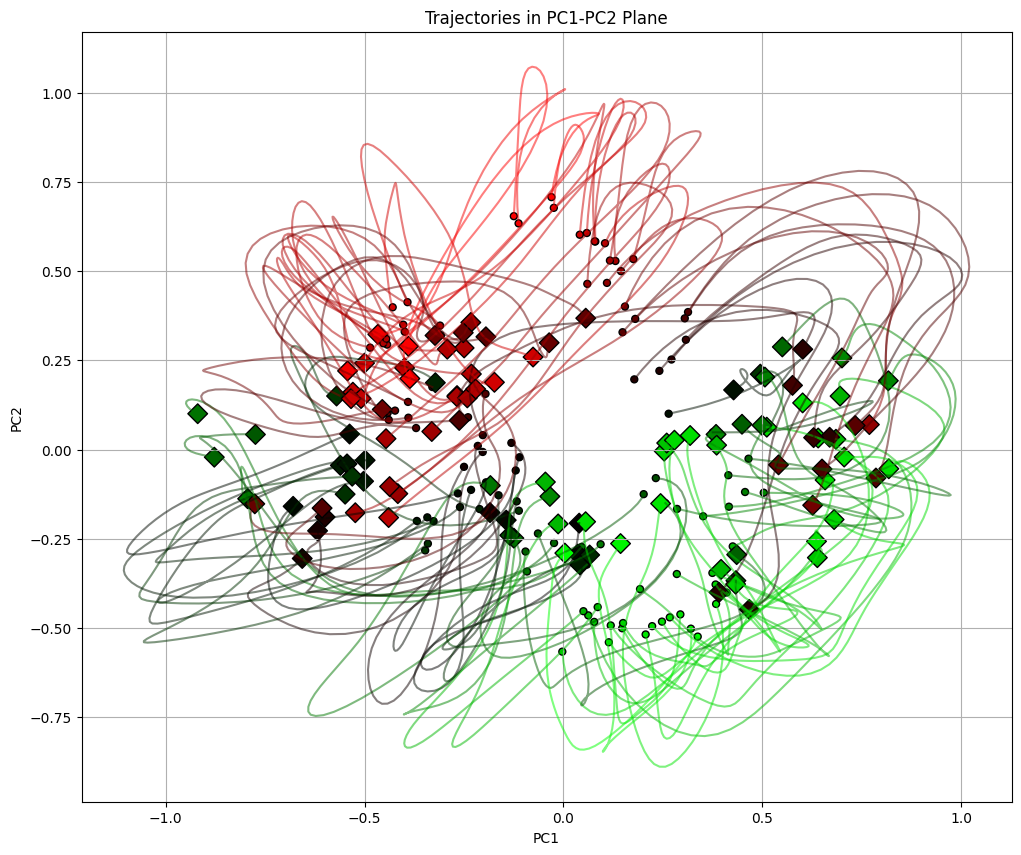

In [ ]:
# Initialize the plot
plt.figure(figsize=(12, 10))

# Plot each condition's trajectory
for condition in range(num_conditions):
    plt.plot(PC1[condition, :], PC2[condition, :], color=colors[condition], alpha=0.5)

# Mark the starting points of each trajectory
plot_start(initial_PC1, initial_PC2, colors, markersize=100)

# Extract the end points of each trajectory (at +300 ms, t=45)
end_PC1 = PC1[:, -1]  # Shape: (108,)
end_PC2 = PC2[:, -1]  # Shape: (108,)

# Mark the ending points of each trajectory
plot_end(end_PC1, end_PC2, colors, markersize=100)

# Customize the plot
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Trajectories in PC1-PC2 Plane')
plt.grid(True)

# Optional: Add a legend or other annotations if necessary
# Note: With 108 conditions, a legend might be cluttered. Consider excluding it or providing a subset.

# Display the plot
plt.show()


# Exercise 4

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def determine_K(M):
    return M * (M - 1) // 2

def construct_H(M):
    K = determine_K(M)
    H = np.zeros((K, M, M))

    a = 0  # Parameter index
    for i in range(M):
        for j in range(i + 1, M):
            H[a, i, j] = 1   # Above-diagonal element
            H[a, j, i] = -1  # Below-diagonal element
            a += 1
    return H

def parametrize_A(beta, H):
    A = np.tensordot(beta, H, axes=1)
    # Ensure that diagonal elements are zero
    np.fill_diagonal(A, 0)
    return A

def compute_gradient_beta(H, Z_subset, Delta_Z_reshaped):
    # Compute W: W_{a,i,n} = sum_j H_{a,i,j} Z_{j,n}
    # H has shape (K, M, M), Z_subset has shape (M, N)
    # W will have shape (K, M, N)
    W = np.einsum('aij,jn->ain', H, Z_subset)

    # Reshape W to (K, M*N)
    K, M, N = W.shape
    W_reshaped = W.reshape(K, M * N)

    # Reshape Delta_Z_reshaped to (M*N,)
    Delta_Z_flat = Delta_Z_reshaped.reshape(M * N)

    # Compute Q = W * W^T, which is (K, K)
    Q = W_reshaped @ W_reshaped.T  # Shape: (K, K)

    # Compute b = W * Delta_Z, which is (K,)
    b = W_reshaped @ Delta_Z_flat  # Shape: (K,)

    return Q, b

def compute_beta_MLE(Q, b):
    # Check if Q is invertible
    if np.linalg.matrix_rank(Q) == Q.shape[0]:
        beta_MLE = np.linalg.solve(Q, b)
    else:
        # If Q is singular, use pseudo-inverse
        beta_MLE = np.linalg.pinv(Q) @ b
        print("Warning: Q is singular; using pseudo-inverse to compute beta_MLE.")
    return beta_MLE

def plot_matrix_A(A, title="Antisymmetric Matrix A"):
    plt.figure(figsize=(8, 6))
    im = plt.imshow(A, cmap='coolwarm', interpolation='none')
    plt.title(title)
    plt.xlabel('Column Index')
    plt.ylabel('Row Index')

    M, _ = A.shape
    for i in range(M):
        for j in range(M):
            plt.text(j, i, f"{A[i, j]:.2f}", ha="center", va="center", color="black")

    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

def estimate_A(Z, M=12, C=108, T=46):
    # Step 1: Reshape Z into (M, C, T)
    Z_reshaped = Z.reshape(M, C, T)

    # Step 2: Compute Delta Z along the time axis within each condition
    Delta_Z = Z_reshaped[:, :, 1:] - Z_reshaped[:, :, :-1]  # Shape: (M, C, T-1)

    # Step 3: Reshape Z and Delta Z into 2D arrays for matrix operations
    Z_subset = Z_reshaped[:, :, :-1].reshape(M, C * (T - 1))      # Shape: (M, C*(T-1))
    Delta_Z_reshaped = Delta_Z.reshape(M, C * (T - 1))           # Shape: (M, C*(T-1))

    # Step 4: Construct tensor H
    H = construct_H(M)                                          # Shape: (K, M, M)
    K = determine_K(M)

    # Step 5: Compute Q and b based on the data
    Q, b = compute_gradient_beta(H, Z_subset, Delta_Z_reshaped)

    # Step 6: Compute beta_MLE
    beta_MLE = compute_beta_MLE(Q, b)                        # Shape: (K,)

    # Step 7: Construct A from beta_MLE
    A_estimated = parametrize_A(beta_MLE, H)                 # Shape: (M, M)

    return A_estimated

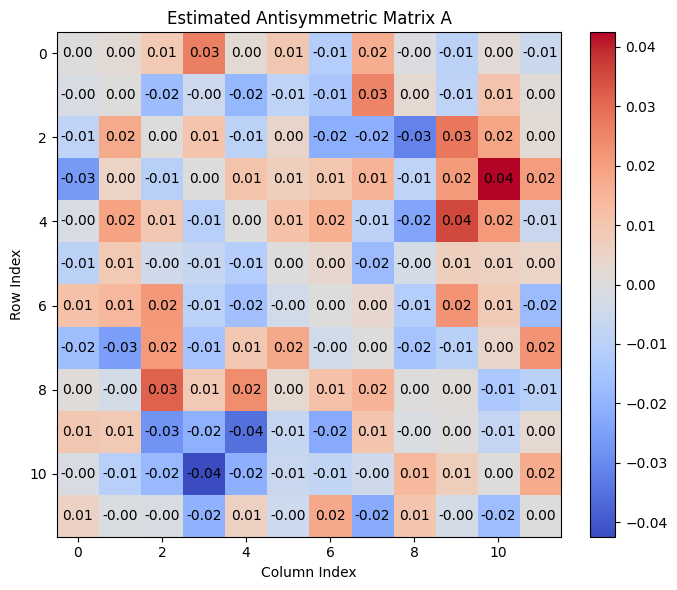

In [ ]:
def apply_estimate_A():

    # Estimate A from Z
    A_est = estimate_A(Z)

    # Plot the estimated A and the ground truth A_test
    plot_matrix_A(A_est, title="Estimated Antisymmetric Matrix A")

    return A_est

A_est = apply_estimate_A()

In [ ]:
def test_estimate_A():

    # Load test data
    try:
        test_data = np.load('test.npz')
        Z_test = test_data['Z_test']    # Shape: (M, C*T)
        A_test = test_data['A_test']    # Shape: (M, M)
    except FileNotFoundError:
        print("Error: 'test.npz' file not found in the current directory.")
        return
    except KeyError:
        print("Error: 'test.npz' does not contain 'Z_test' and 'A_test' arrays.")
        return

    # Estimate A from Z_test
    A_est2 = estimate_A(Z_test)

    # Compute maximum absolute difference
    max_abs_diff = np.max(np.abs(A_est2 - A_test))

    print(f"Maximum absolute difference between estimated A and A_test: {max_abs_diff:.20f}")

    # Check if the difference is within the acceptable threshold
    threshold = 1e-8
    if max_abs_diff <= threshold:
        print(f"Test Passed: Maximum absolute difference ({max_abs_diff:.10f}) <= {threshold}")
    else:
        print(f"Test Failed: Maximum absolute difference ({max_abs_diff:.10f}) > {threshold}")



    return A_est2


A_est2 = test_estimate_A()

Error: 'test.npz' file not found in the current directory.


# Exercise 5

Z shape: (12, 4968)
A_est shape: (12, 12)
Selected Eigenvalue: (-2.6020852139652106e-18+0.09182414138639863j)
Corresponding Angular Velocity (omega): 0.091824

Projection Matrix P_FR (2 x 12):
[[ 0.20299644 -0.30121733 -0.01156132  0.04915709  0.11243293 -0.12275795
   0.00957348  0.1311047   0.43634368 -0.5746701  -0.54339422 -0.06782993]
 [-0.07044238 -0.021036    0.55132489  0.48248272  0.55307182  0.18481689
   0.26907345  0.0274601  -0.14046831  0.          0.00819263 -0.1576321 ]]

Projected Data Z_proj shape: (2, 108, 46)



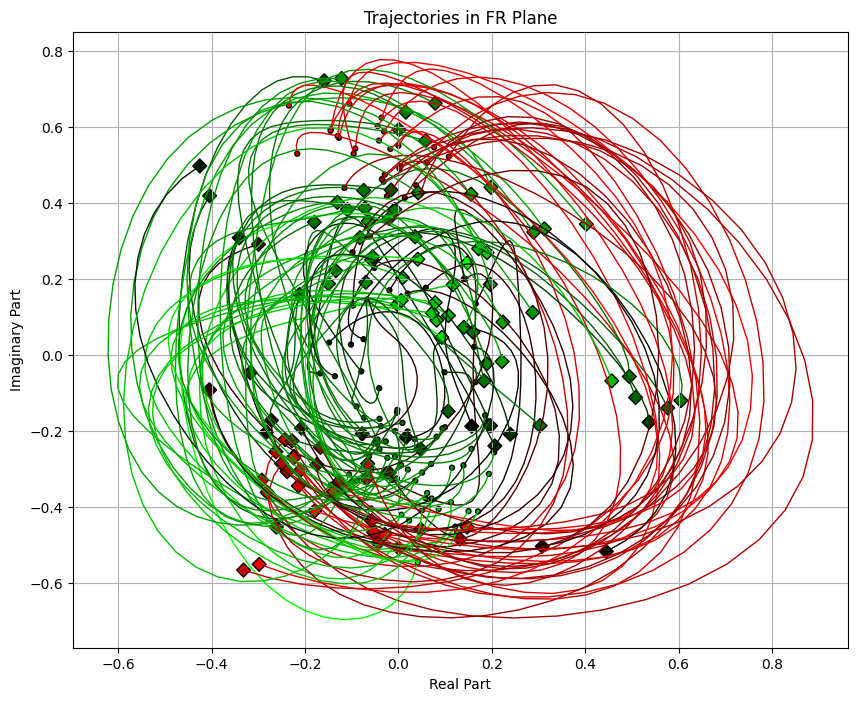

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import importlib
from cond_color import get_colors, plot_start, plot_end  # Ensure this matches the filename without .py


# --- Part a: Eigenvalue and Eigenvector Analysis ---

def compute_eigen_decomposition(A):
    """
    Computes the eigenvalues and eigenvectors of an antisymmetric matrix A.

    Parameters:
    - A: numpy.ndarray of shape (M, M), antisymmetric matrix

    Returns:
    - eigenvalues: numpy.ndarray of shape (M,), eigenvalues of A
    - eigenvectors: numpy.ndarray of shape (M, M), eigenvectors of A
    """
    eigenvalues, eigenvectors = np.linalg.eig(A)
    return eigenvalues, eigenvectors

def select_fastest_eigenpair(eigenvalues, eigenvectors):
    """
    Selects the eigenvalue with the largest imaginary part and its corresponding eigenvector.

    Parameters:
    - eigenvalues: numpy.ndarray of shape (M,), eigenvalues of A
    - eigenvectors: numpy.ndarray of shape (M, M), eigenvectors of A

    Returns:
    - fastest_eigenvalue: complex, eigenvalue with largest imaginary part
    - fastest_eigenvector: numpy.ndarray of shape (M,), corresponding eigenvector
    """
    # Compute the imaginary parts of all eigenvalues
    imag_parts = np.imag(eigenvalues)

    # Find the index of the eigenvalue with the maximum imaginary part
    fastest_idx = np.argmax(imag_parts)

    # Retrieve the corresponding eigenvalue and eigenvector
    fastest_eigenvalue = eigenvalues[fastest_idx]
    fastest_eigenvector = eigenvectors[:, fastest_idx]

    return fastest_eigenvalue, fastest_eigenvector

# --- Part b: Constructing Projection Matrix and Projecting Z_test ---

def construct_P_FR(eigenvector):
    """
    Constructs the 2xM projection matrix P_FR from the normalized real and imaginary parts of the eigenvector.

    Parameters:
    - eigenvector: numpy.ndarray of shape (M,), complex eigenvector

    Returns:
    - P_FR: numpy.ndarray of shape (2, M), projection matrix
    """
    # Extract real and imaginary parts of the eigenvector
    real_part = np.real(eigenvector)
    imag_part = np.imag(eigenvector)

    # Normalize each part to unit length
    real_norm = real_part / np.linalg.norm(real_part)
    imag_norm = imag_part / np.linalg.norm(imag_part)

    # Stack as a 2xM matrix
    P_FR = np.vstack((real_norm, imag_norm))

    return P_FR

def project_Z(P_FR, Z):
    """
    Projects the data matrix Z onto the FR plane using projection matrix P_FR.

    Parameters:
    - P_FR: numpy.ndarray of shape (2, M), projection matrix
    - Z: numpy.ndarray of shape (M, C, T), data matrix

    Returns:
    - Z_proj: numpy.ndarray of shape (2, C, T), projected data
    """

    # Perform matrix multiplication
    Z_proj_flat = P_FR @ Z  # Shape: (2, )

    # Reshape back to (2, C, T)
    Z_proj = Z_proj_flat.reshape(2, 108, 46)  # Shape: (2, 108, 36)

    return Z_proj

# --- Part c: Plotting 2D Trajectories ---

def plot_2D_trajectories(Z_proj, alt=False):

    # Extract the initial points of each trajectory (at first time bin)
    initial_Real = Z_proj[0, :, 0]  # Shape: (C,)
    initial_Imag = Z_proj[1, :, 0]  # Shape: (C,)

    # Since we're only plotting the first 36 indices, the end point is at index 35
    end_Real = Z_proj[0, :, -1]  # Shape: (C,)
    end_Imag = Z_proj[1, :, -1]  # Shape: (C,)

    # Assign colors based on initial points using get_colors
    colors = get_colors(initial_Real, initial_Imag)

    # Initialize the plot
    plt.figure(figsize=(10, 8))

    # Plot each condition's trajectory within the selected time interval
    for condition in range(108):
        plt.plot(Z_proj[0, condition, :], Z_proj[1, condition, :],
                 color=colors[condition], alpha=1, linewidth=1)

    # Mark the starting points of each trajectory
    plot_start(initial_Real, initial_Imag, colors, markersize=50)

    # Mark the ending points of each trajectory
    plot_end(end_Real, end_Imag, colors, markersize=50)

    # Customize the plot
    plt.xlabel('Real Part')
    plt.ylabel('Imaginary Part')
    plt.title('Trajectories in FR Plane')
    plt.grid(True)

    # Display the plot
    plt.show()

# --- Main Execution ---

def main():
    """
    Main function to execute Exercise 5, Parts a, b, and c.
    """
    # Determine M, C, and T
    M_z, C_T = Z.shape
    C = 108
    T = 36
    M = A_est.shape[0] # A_est from exercise 4
    if M_z != M or A_est.shape[0] != A_est.shape[1]:
        print("Error: Mismatch in dimensions between A_est and Z.")
        print(f"A_est shape: {A_est.shape}")
        print(f"Z_test shape: {Z.shape}")
        return

    # Define time_vector
    start_time = -150  # in ms
    end_time = 200     # in ms
    #time_vector = np.linspace(start_time, end_time, T)  # Shape: (T,)

    # --- Diagnostic Prints ---
    print(f"Z shape: {Z.shape}")  # Expected: (12, 108*46)
    print(f"A_est shape: {A_est.shape}")    # Expected: (12, 12)
    #print(f"time_vector shape: {time_vector.shape}\n")  # Expected: (46,)

    # --- Part a: Compute Eigenvalues and Eigenvectors ---
    eigenvalues, eigenvectors = compute_eigen_decomposition(A_est)

    # --- Select Eigenvalue with Largest Imaginary Part ---
    fastest_eigenvalue, fastest_eigenvector = select_fastest_eigenpair(eigenvalues, eigenvectors)
    omega = np.imag(fastest_eigenvalue)

    print(f"Selected Eigenvalue: {fastest_eigenvalue}")
    print(f"Corresponding Angular Velocity (omega): {omega:.6f}\n")

    # --- Part b: Construct P_FR and Project Z_test ---
    P_FR = construct_P_FR(fastest_eigenvector)
    print(f"Projection Matrix P_FR (2 x {M}):\n{P_FR}\n")

    Z_proj = project_Z(P_FR, Z)  # Shape: (2, C, T)
    print(f"Projected Data Z_proj shape: {Z_proj.shape}\n")

    Z_proj_trun = Z_proj[:,:,:-10]

    # Define the time interval for plotting
    plot_start_time = -150  # in ms
    plot_end_time = 200     # in ms

    plot_2D_trajectories(Z_proj_trun)

    return Z_proj, P_FR, colors

Z_proj, P_FR, colors = main()


question 6 using P_ER from the eigenvector corresponding to eigenvalue with largest imgainary part

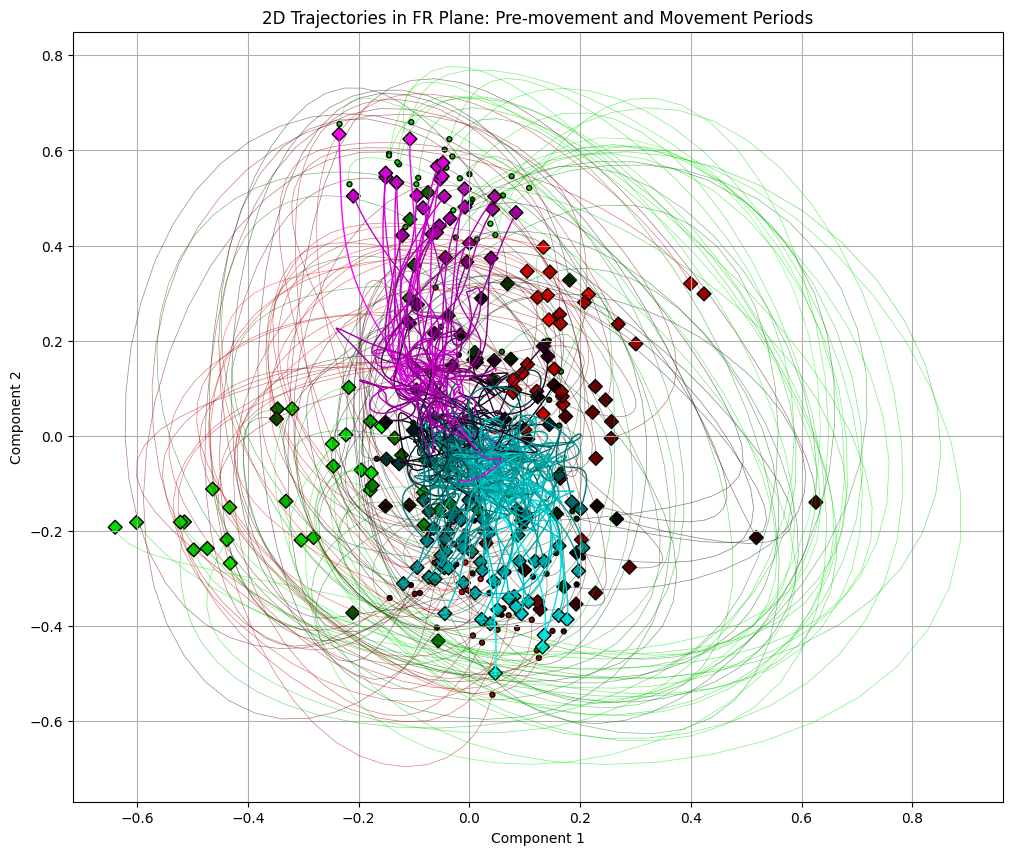

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import importlib
from cond_color import get_colors, plot_start, plot_end  # Ensure this matches the filename without .py

# --- Utility Functions ---

def plot_superimposed_trajectories(Z_proj_movement, Z_proj_premovement, colors_movement, colors_premovement, C, T_movement, T_premovement, start_time, end_time):
    """
    Plots both movement and pre-movement trajectories on the FR plane.

    Parameters:
    - Z_proj_movement: numpy.ndarray of shape (2, C, T_movement), movement period projections
    - Z_proj_premovement: numpy.ndarray of shape (2, C, T_premovement), pre-movement period projections
    - colors_movement: list of colors for movement trajectories
    - colors_premovement: list of colors for pre-movement trajectories
    - C: int, number of conditions
    - T_movement: int, number of time bins for movement period
    - T_premovement: int, number of time bins for pre-movement period
    - start_time: float, start time in ms for movement period
    - end_time: float, end time in ms for movement period

    Returns:
    - None
    """
    plt.figure(figsize=(12, 10))

    # Plot Movement Trajectories with low alpha for less clutter
    for condition in range(C):
        plt.plot(Z_proj_movement[0, condition, :], Z_proj_movement[1, condition, :],
                 color=colors_movement[condition], alpha=0.5, linewidth=0.5)

    # Plot Pre-movement Trajectories with higher alpha and different color coding
    for condition in range(C):
        plt.plot(Z_proj_premovement[0, condition, :], Z_proj_premovement[1, condition, :],
                 color=colors_premovement[condition], alpha=1, linewidth=1)

    # Mark the starting points of movement trajectories
    plot_start(Z_proj_movement[0, :, 0], Z_proj_movement[1, :, 0], colors_movement, markersize=50)

    # Mark the ending points of movement trajectories
    plot_end(Z_proj_movement[0, :, -1], Z_proj_movement[1, :, -1], colors_movement, markersize=50)

    # Mark the final points of pre-movement trajectories as starting points (for visual distinction)
    plot_start(Z_proj_premovement[0, :, -1], Z_proj_premovement[1, :, -1], colors_premovement, markersize=50)

    # Mark the final points of pre-movement trajectories
    plot_end(Z_proj_premovement[0, :, -1], Z_proj_premovement[1, :, -1], colors_premovement, markersize=50)

    # Customize the plot
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title('2D Trajectories in FR Plane: Pre-movement and Movement Periods')
    plt.grid(True)

    # Optional: Add a legend or annotations if necessary
    # Note: With 108 conditions, a legend might be cluttered. Consider excluding it or providing a subset.

    # Display the plot
    plt.show()

# --- Main Execution for Exercise 6 ---

def main_exercise6():
    """
    Executes Exercise 6: Project pre-movement period onto FR plane and plot superimposed trajectories.
    """
    # Ensure that the following variables are already defined from previous exercises:
    # - centered_X: numpy.ndarray of shape (N=182, C=108, T=130), normalized and mean-centered PSTHs
    # - V_M: numpy.ndarray of shape (N=182, M=12), PCA projection matrix
    # - A_est: numpy.ndarray of shape (M=12, M=12), estimated antisymmetric matrix
    # - P_FR: numpy.ndarray of shape (2, M=12), projection matrix onto FR plane
    # - Z_proj: numpy.ndarray of shape (2, C=108, T_movement=46), movement period projections
    # - Real, Imag: numpy.ndarray of shape (C=108, T_movement=46), movement PC1 and PC2
    # - colors: list of length C=108, colors for movement trajectories

    # Verify that necessary variables are defined
    required_vars = ['centered_X', 'V_M', 'A_est', 'P_FR', 'Z_proj', 'colors']
    for var in required_vars:
        if var not in globals():
            print(f"Error: Variable '{var}' is not defined. Please ensure all previous exercises are completed.")
            return

    # 1. Extract Pre-movement Data: first 65 time bins (-800 ms to -150 ms)
    X_pre_movement = centered_X[:, :, :65]  # Shape: (182, 108, 65)

    # 2. Reshape and Project onto PC Space
    # Reshape to (N=182, C*T_pre=108*65=7020)
    X_pre_movement_reshaped = X_pre_movement.reshape(182, 108 * 65)  # Shape: (182, 7020)

    # Project onto PC space using V_M: (M=12, N=182) @ (N=182, C*T=7020) => (M=12, 7020)
    Z_pre = V_M.T @ X_pre_movement_reshaped  # Shape: (12, 7020)

    # 3. Project onto FR Plane using P_FR: (2, M=12) @ (12, 7020) => (2, 7020)
    Z_pre_FR = P_FR @ Z_pre  # Shape: (2, 7020)

    # 4. Reshape Z_pre_FR to (2, C=108, T_premovement=65)
    Z_pre_FR = Z_pre_FR.reshape(2, 108, 65)  # Shape: (2, 108, 65)

    # 5. Assign Colors for Pre-movement Trajectories
    # Use the final points of pre-movement trajectories for color assignment
    final_PC1_premovement = Z_pre_FR[0, :, -1]  # Shape: (108,)
    final_PC2_premovement = Z_pre_FR[1, :, -1]  # Shape: (108,)

    # Use get_colors with alt_colors=True for different color coding
    colors_premovement = get_colors(final_PC1_premovement, final_PC2_premovement, alt_colors=True)

    # Verify that the number of colors matches the number of conditions
    if len(colors_premovement) != 108:
        print(f"Error: Number of pre-movement colors ({len(colors_premovement)}) does not match number of conditions (108).")
        return

    # 6. Superimpose Pre-movement Trajectories on Movement Trajectories
    plot_superimposed_trajectories(
        Z_proj_movement=Z_proj,              # Movement period projections (2, 108, 46)
        Z_proj_premovement=Z_pre_FR,         # Pre-movement period projections (2, 108, 65)
        colors_movement=colors,               # Colors for movement trajectories
        colors_premovement=colors_premovement,  # Colors for pre-movement trajectories
        C=108,                                # Number of conditions
        T_movement=46,                        # Number of time bins for movement period
        T_premovement=65,                     # Number of time bins for pre-movement period
        start_time=-150,                      # Start time for movement period (ms)
        end_time=200                          # End time for movement period (ms)
    )

# Execute Exercise 6
main_exercise6()


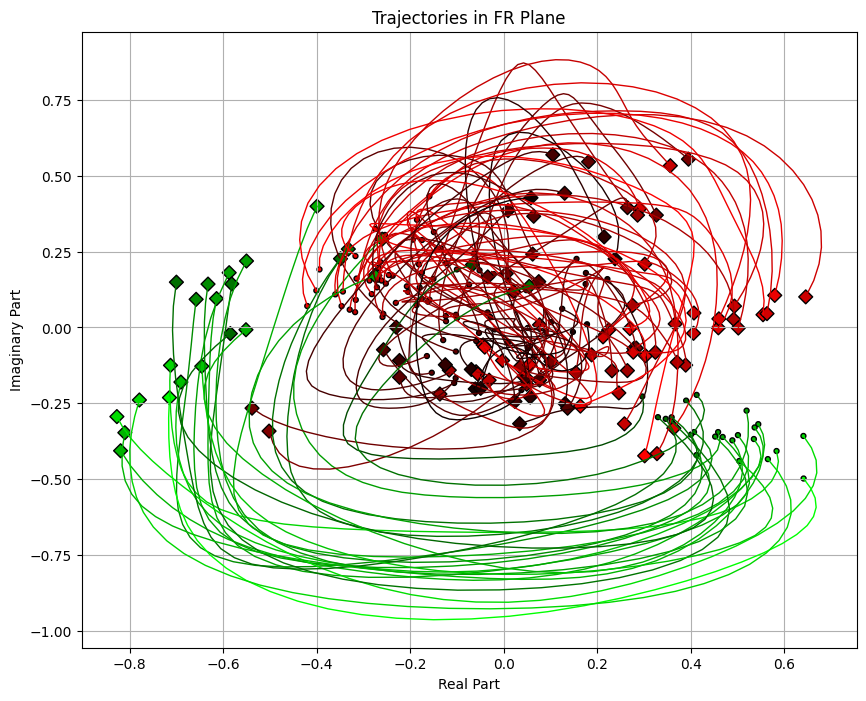

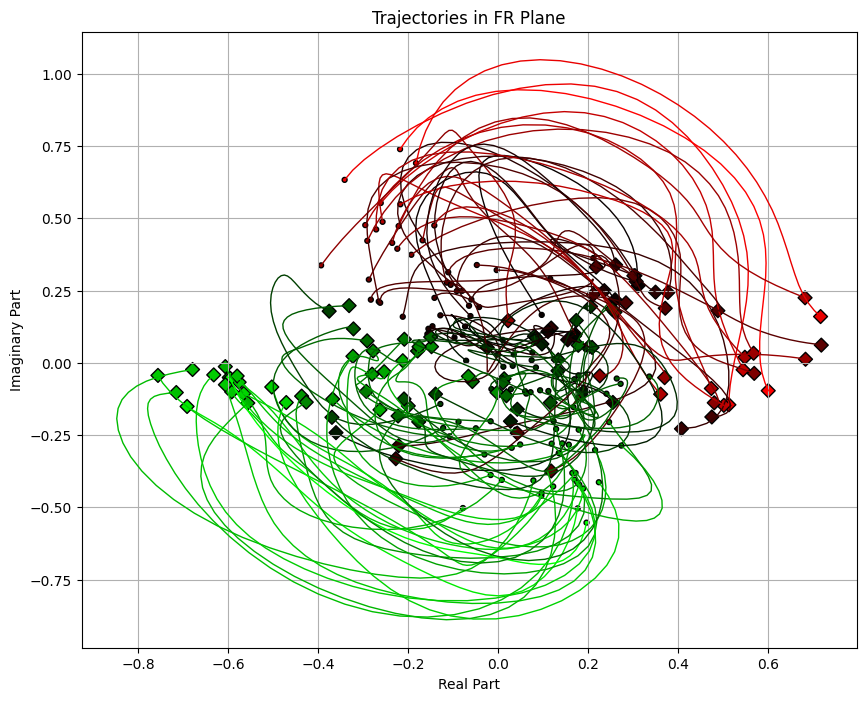

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

eigenvalues, eigenvectors = np.linalg.eig(A_est)

# Step 2: Sort eigenvalues and eigenvectors by the magnitude of their imaginary parts in descending order
sorted_indices = np.argsort(-np.abs(np.imag(eigenvalues)))
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

# Step 3: Define parameters for plotting
C = 108
T = 36
start_time, end_time = -150, 200  # Time interval in ms

# Step 4: Loop through the second and third largest imaginary parts (indices 1 and 2)
for i in [2,4]:  # Indices for second and third largest imaginary parts
    eigenvector = eigenvectors[:, i]

    # Construct the projection matrix P_FR for the current eigenvector
    P_FR = construct_P_FR(eigenvector)

    # Project Z onto the FR plane defined by P_FR
    Z_proj = project_Z(P_FR, Z)

    Z_proj_trun = Z_proj[:,:,:-10]

    # Plot the 2D trajectories in the FR plane
    plot_2D_trajectories(Z_proj_trun)

# Exercise 6


did in exercise 5

# Exercise 7

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from cond_color import get_colors, plot_start, plot_end  # Ensure this matches the filename without .py
import copy  # For deep copying data

In [ ]:
def invert_movement_period(X, times, invert_half=True, random_seed=42):
    np.random.seed(random_seed)
    X_inverted = copy.deepcopy(X)  # To avoid modifying the original data

    N, C, T = X.shape

    # Identify the index for -150 ms
    t0_candidates = np.where(times == -150)[0]
    if len(t0_candidates) == 0:
        raise ValueError("Time bin at -150 ms not found in 'times' array.")
    t0 = t0_candidates[0]

    for neuron in range(N):
        # Randomly pick half of the conditions
        half_C = C // 2
        inverted_conditions = np.random.choice(C, half_C, replace=False)

        for condition in inverted_conditions:
            # Invert the movement-period segment
            X_inverted[neuron, condition, t0:T] = 2 * X_inverted[neuron, condition, t0] - X_inverted[neuron, condition, t0:T]

    return X_inverted

def shuffle_time_bins(X, random_seed=42):
    np.random.seed(random_seed)
    X_shuffled_time = copy.deepcopy(X)
    N, C, T = X.shape

    for neuron in range(N):
        for condition in range(C):
            shuffled_indices = np.random.permutation(T)
            X_shuffled_time[neuron, condition, :] = X_shuffled_time[neuron, condition, shuffled_indices]

    return X_shuffled_time

def shuffle_conditions_per_neuron(X, random_seed=42):
    np.random.seed(random_seed)
    X_shuffled_conditions = copy.deepcopy(X)
    N, C, T = X.shape

    for neuron in range(N):
        shuffled_conditions = np.random.permutation(C)
        X_shuffled_conditions[neuron, :, :] = X_shuffled_conditions[neuron, shuffled_conditions, :]

    return X_shuffled_conditions


In [ ]:
# Assume X and times have been loaded previously

# Apply Inversion Distortion
X_inverted = invert_movement_period(X, times, invert_half=True, random_seed=42)

# Apply Time Shuffle Distortion
X_shuffled_time = shuffle_time_bins(X, random_seed=42)

# Apply Condition Shuffle Distortion
X_shuffled_conditions = shuffle_conditions_per_neuron(X, random_seed=42)


Re-run Computational Steps

In [ ]:
from sklearn.decomposition import PCA

def process_X(X_distorted, times, V_M=None, M=12, start_time=-150, end_time=300):
    # 1. Normalization
    N, C, T = X_distorted.shape
    a = X_distorted.max(axis=(1, 2), keepdims=True)  # Shape: (N, 1, 1)
    b = X_distorted.min(axis=(1, 2), keepdims=True)  # Shape: (N, 1, 1)
    X_normalized = (X_distorted - b) / (a - b + 5)

    # 2. Mean Centering
    mean_over_conditions = X_normalized.mean(axis=1, keepdims=True)  # Shape: (N, 1, T)
    X_centered = X_normalized - mean_over_conditions  # Shape: (N, C, T)

    # 3. Select Time Interval
    selected_time_mask = (times >= start_time) & (times <= end_time)  # Shape: (T,)
    selected_times = times[selected_time_mask]
    selected_X = X_centered[:, :, selected_time_mask]  # Shape: (N, C, T_p=46)

    # 4. Reshape for PCA
    N, C, T_p = selected_X.shape
    CT = C * T_p
    reshaped_X = selected_X.reshape(N, CT).T  # Shape: (CT, N)

    # 5. PCA
    if V_M is None:
        # Fit PCA on distorted data
        pca = PCA(n_components=M)
        pca.fit(reshaped_X)
        V_M = pca.components_.T  # Shape: (N, M)
    else:
        # Use existing PCA projection matrix
        pass

    # Project onto PCA space
    Z = V_M.T @ selected_X.reshape(N, C * T_p)  # Shape: (M, CT)

    # 6. Estimate A (antisymmetric matrix)
    # Following Exercise 4's maximum-likelihood estimation

    # Reshape Z into (M, C, T_p)
    Z_reshaped = Z.reshape(M, C, T_p)  # Shape: (M, C, T_p)

    # Compute Delta Z
    Delta_Z = Z_reshaped[:, :, 1:] - Z_reshaped[:, :, :-1]  # Shape: (M, C, T_p -1)

    # Reshape Z and Delta Z for matrix operations
    Z_subset = Z_reshaped[:, :, :-1].reshape(M, C * (T_p -1))  # Shape: (M, C*(T_p -1))
    Delta_Z_reshaped = Delta_Z.reshape(M, C * (T_p -1))       # Shape: (M, C*(T_p -1))

    # Construct tensor H
    K = M * (M -1) // 2
    H = np.zeros((K, M, M))
    a_idx = 0
    for i in range(M):
        for j in range(i +1, M):
            H[a_idx, i, j] = 1
            H[a_idx, j, i] = -1
            a_idx +=1

    # Compute W
    W = np.einsum('aij,jn->ain', H, Z_subset)  # Shape: (K, M, N), N=C*(T_p -1)
    K_val, M_val, N_val = W.shape
    W_reshaped = W.reshape(K_val, M_val * N_val)  # Shape: (K, M*N)
    Delta_Z_flat = Delta_Z_reshaped.reshape(M_val * N_val)  # Shape: (M*N,)

    # Compute Q and b
    Q = W_reshaped @ W_reshaped.T  # Shape: (K, K)
    b = W_reshaped @ Delta_Z_flat  # Shape: (K,)

    # Solve for beta
    if np.linalg.matrix_rank(Q) == K:
        beta_MLE = np.linalg.solve(Q, b)  # Shape: (K,)
    else:
        beta_MLE = np.linalg.pinv(Q) @ b  # Shape: (K,)
        print("Warning: Q is singular; using pseudo-inverse to compute beta_MLE.")

    # Construct A
    A_est = np.tensordot(beta_MLE, H, axes=1)  # Shape: (M, M)
    np.fill_diagonal(A_est, 0)  # Ensure diagonal is zero

    # 7. Eigen Decomposition of A
    eigenvalues, eigenvectors = np.linalg.eig(A_est)

    # Select the eigenvalue with the largest imaginary part
    imag_parts = np.imag(eigenvalues)
    fastest_idx = np.argmax(imag_parts)
    fastest_eigenvalue = eigenvalues[fastest_idx]
    fastest_eigenvector = eigenvectors[:, fastest_idx]

    # Construct Projection Matrix P_FR
    real_part = np.real(fastest_eigenvector)
    imag_part = np.imag(fastest_eigenvector)
    real_norm = real_part / np.linalg.norm(real_part)
    imag_norm = imag_part / np.linalg.norm(imag_part)
    P_FR = np.vstack((real_norm, imag_norm))  # Shape: (2, M)

    # Project Z onto FR plane
    Z_proj = np.tensordot(P_FR, Z_reshaped, axes=([1], [0]))  # Shape: (2, C, T_p)

    # Assign Colors based on initial points
    initial_PC1 = Z_proj[0, :, 0]  # Shape: (C,)
    initial_PC2 = Z_proj[1, :, 0]  # Shape: (C,)
    colors_new = get_colors(initial_PC1, initial_PC2)  # List of colors

    # Plot 2D Trajectories in FR Plane
    plt.figure(figsize=(12, 10))
    for condition in range(C):
        plt.plot(Z_proj[0, condition, :], Z_proj[1, condition, :],
                 color=colors_new[condition], alpha=1, linewidth=1)

    # Mark Start and End Points
    plot_start(initial_PC1, initial_PC2, colors_new, markersize=50)
    end_PC1 = Z_proj[0, :, -1]
    end_PC2 = Z_proj[1, :, -1]
    plot_end(end_PC1, end_PC2, colors_new, markersize=50)

    plt.xlabel('FR Component 1')
    plt.ylabel('FR Component 2')
    plt.title('2D Trajectories in FR Plane (Distorted Data)')
    plt.grid(True)
    plt.show()

    return Z_proj, A_est, P_FR, colors_new


In [ ]:
# Define a function to process and plot each distorted dataset
def analyze_distortion(X_distorted, times, distortion_type):
    print(f"\n--- Analyzing Distortion: {distortion_type} ---")

    # Process the distorted data
    Z_proj_distorted, A_est_distorted, P_FR_distorted, colors_distorted = process_X(X_distorted, times)

    # Optionally, plot the antisymmetric matrix A
    # plot_matrix_A(A_est_distorted, title=f"Antisymmetric Matrix A ({distortion_type})")

    # The function process_X already plots the trajectories
    # Additional plots or analyses can be added here if necessary

# Analyze Primary Distortion (Inversion)
analyze_distortion(X_inverted, times, distortion_type="Inversion")

# Analyze Control Distortion 1 (Time Shuffle)
analyze_distortion(X_shuffled_time, times, distortion_type="Time Shuffle")

# Analyze Control Distortion 2 (Condition Shuffle)
analyze_distortion(X_shuffled_conditions, times, distortion_type="Condition Shuffle")


Output hidden; open in https://colab.research.google.com to view.